In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [26]:
df_final = pd.read_csv('train_final_complete.csv')

In [25]:
features = ['built_year', 'num_beds', 'num_baths', 'lat', 'lng', 'size_sqft',
                    'tenure_group', 'subzone_per_price_encoded',
                    'property_type_ordinal',
                  'dist_to_nearest_important_mrt_rounded',
                    #schools
                    'number_of_nearby_primary_schools', 
                    'number_of_nearby_secondary_schools', 
                    #shopping mall
                    'number_of_nearby_shopping_malls',
                    #CR
                    #'name_of_nearest_IHL_ordinal',
                    'name_of_nearest_BN_ordinal',
                    'name_of_nearest_CR_ordinal']

In [22]:
def gen_seg(minthre,maxthre,gt):
    return gt[(gt.per_price>minthre)&(gt.per_price<=maxthre)].index

In [23]:
def format_predicted(predicted):
  df_predicted = pd.DataFrame(predicted)
  df_predicted.columns = ['Predicted']
  df_predicted['Id'] = df_predicted.index
  df_predicted = df_predicted.reindex(columns=['Id', 'Predicted'])
  return df_predicted

In [20]:
thres = [[0,600],[600,1200],[1200,1800],[1800,2400],[2400,3000],[3000,df_final.price.max()+1]]

# Random Forest

In [27]:
best_random_forest_regressor = RandomForestRegressor(max_depth=50, max_features=8, n_estimators=200)
best_random_forest_regressor.fit(df_final[features], df_final['per_price'])
random_forest_predicted = best_random_forest_regressor.predict(df_final[features])
random_forest_predicted = random_forest_predicted * df_final['size_sqft'] # convert price per square feet to price
random_forest_predicted = format_predicted(random_forest_predicted)

In [30]:
random_forest_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_final)
    gt = df_final.iloc[idxs].price
    pred = random_forest_predicted[random_forest_predicted.Id.isin(idxs)].Predicted
    random_forest_mses.append(mean_squared_error(gt,pred))
print(random_forest_mses)

[58947441006.22547, 141458569556.26398, 141283351093.07343, 670141710890.7765, 306957023884.3538, 2689235792918.289]


# Gradient Boosting

In [31]:
best_gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.5, max_depth=4, n_estimators=400)
best_gradient_boosting_regressor.fit(df_final[features], df_final['per_price'])
gradient_boosting_predicted = best_gradient_boosting_regressor.predict(df_final[features])
gradient_boosting_predicted = gradient_boosting_predicted * df_final['size_sqft'] # convert price per square feet to price
gradient_boosting_predicted = format_predicted(gradient_boosting_predicted)

In [32]:
gradient_boosting_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_final)
    gt = df_final.iloc[idxs].price
    pred = gradient_boosting_predicted[gradient_boosting_predicted.Id.isin(idxs)].Predicted
    gradient_boosting_mses.append(mean_squared_error(gt,pred))
print(gradient_boosting_mses)

[3983083000.4228053, 48468602674.997696, 104660693390.19313, 154757239358.24817, 124260842622.22356, 668456659304.0635]


# Comparison

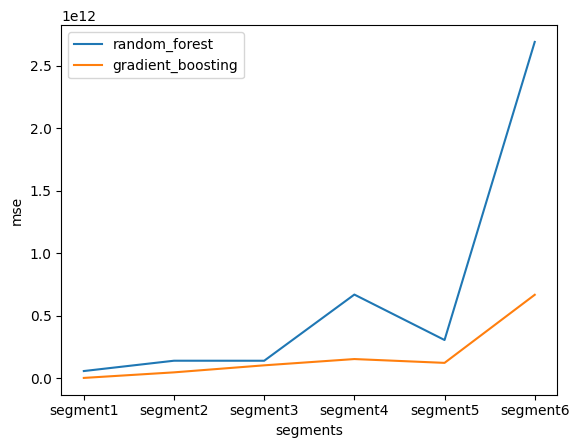

In [33]:
x_axis = ["segment1", "segment2", "segment3", "segment4", "segment5", "segment6"]
random_forest_line = plt.plot(x_axis, random_forest_mses, label='random_forest')
gradient_boosting_line = plt.plot(x_axis, gradient_boosting_mses, label='gradient_boosting')
plt.xlabel("segments")
plt.ylabel("mse")
plt.legend()
plt.show()